In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import cv2

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import pathlib

import tensorflow as tf
from tensorflow.keras import backend as K
from IPython.display import clear_output
%matplotlib inline

In [2]:

BATCH_SIZE = 64
STEPS_PER_EPOCH = 6400 // BATCH_SIZE
SHUFFLE_BUFFER_SIZE = 1000

folder = './COCOdataset2017'

In [3]:
data_dir = pathlib.Path('{}/images/train_img'.format(folder))
filenames = list(data_dir.glob('*.jpg'))
print("image count: ", len(filenames))

fnames=[]
for fname in filenames:
  fnames.append(str(fname))

image count:  7406


In [4]:
data_dir = pathlib.Path('{}/images/train_mask'.format(folder))
filenames = list(data_dir.glob('*.jpg'))
print("image count: ", len(filenames))

fnames_mask=[]
for fname in filenames:
  fnames_mask.append(str(fname))

image count:  7406


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((fnames, fnames_mask))

In [6]:
VAL_SIZE = 800

training_dataset = train_dataset.skip(VAL_SIZE)

validation_dataset = train_dataset.take(VAL_SIZE)

In [7]:

def process_img(img):
  print("process_img acivated...")
  #color images
  img = tf.image.decode_jpeg(img) 
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32) 
  return img
  
def combine_train_images(file_path,file_path_mask):
  print("combine_images_labels acivated...")
  img = tf.io.read_file(file_path)
  mask = tf.io.read_file(file_path_mask)
  print("image file read...")
  img = process_img(img)
  mask = process_img(mask)
  #mask = tf.image.grayscale_to_rgb(mask)
  if tf.random.uniform(()) > 0.5:
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)

  weights = tf.constant([6.0, 1.0, 1.0])

  sample_weights = tf.gather(weights, indices=tf.cast(mask, tf.int32))

  return img, mask, sample_weights

def combine_val_images(file_path,file_path_mask):
  print("combine_images_labels acivated...")
  img = tf.io.read_file(file_path)
  mask = tf.io.read_file(file_path_mask)
  print("image file read...")
  img = process_img(img)
  mask = process_img(mask)
  #mask = tf.image.grayscale_to_rgb(mask)
  return img, mask

In [8]:
train_dataset=training_dataset.map(combine_train_images,num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = validation_dataset.map(combine_val_images,num_parallel_calls=tf.data.AUTOTUNE)

combine_images_labels acivated...
image file read...
process_img acivated...
process_img acivated...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
combine_images_labels acivated...
image file read...
process_img acivated...
process_img acivated...


In [9]:
training_dataset = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
training_dataset = training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = val_dataset.batch(BATCH_SIZE)

In [10]:
OUTPUT_CHANNELS = 3

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   
    'block_3_expand_relu',  
    'block_6_expand_relu',  
    'block_13_expand_relu',  
    'block_16_project',      #8x8
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [12]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [13]:
up_stack = [
    upsample(512, 3),  
    upsample(256, 3),  
    upsample(128, 3),  
    upsample(64, 3),   #112x112
]

In [14]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #224x224

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
def DiceLoss(y_true, y_pred, smooth=1e-6):
    
    y_pred = tf.math.sigmoid(y_pred)
    
    numerator = (2 * tf.reduce_sum(y_true * y_pred)) + smooth
    denominator = tf.reduce_sum(y_true + y_pred) + smooth

    return 1 - numerator/denominator

In [16]:
def DiceBCELoss(y_true, y_pred, smooth=1e-6):    

    inputs = tf.reshape(y_pred,[-1])
    targets = tf.reshape(y_true,[-1])
    
    BCE = K.binary_crossentropy(targets, inputs)    
    intersection = tf.math.reduce_sum(tf.tensordot(targets, inputs,0))    
    dice_loss = 1 - ((2*intersection + smooth) / (tf.math.reduce_sum(targets) + tf.math.reduce_sum(inputs) + smooth))
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

In [17]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

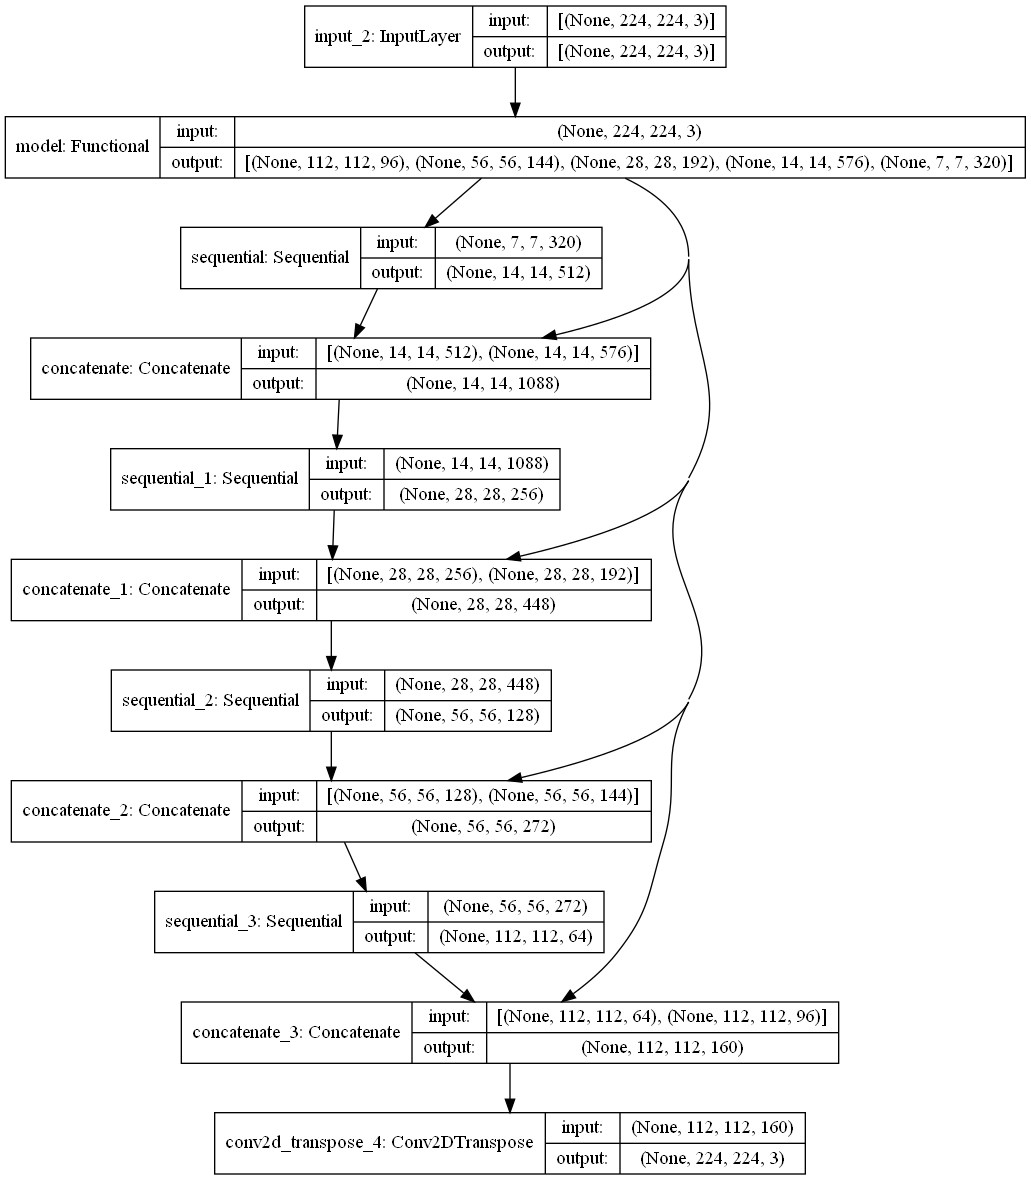

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

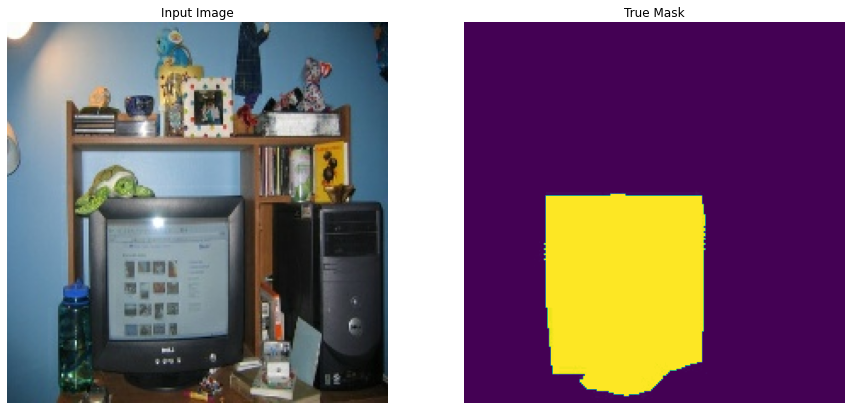

In [20]:
for image, mask in val_dataset.take(5):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [21]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [22]:
def show_predictions(dataset=None, num=10):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

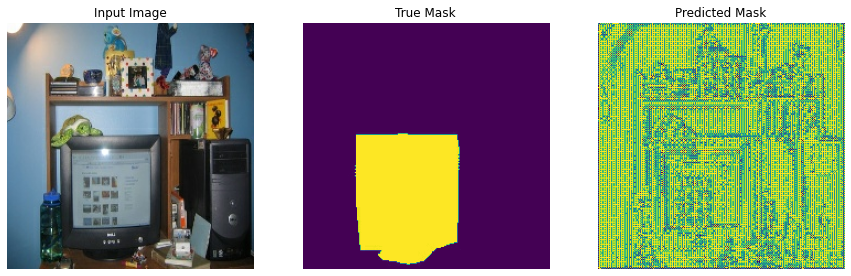

In [23]:
show_predictions()

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

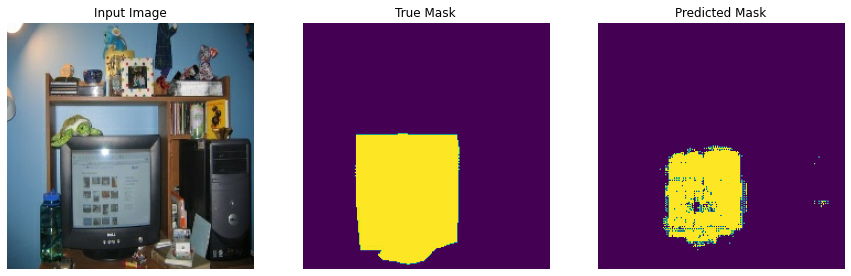


Sample Prediction after epoch 10



In [25]:
EPOCHS = 10
VAL_SPLITS=2
VALIDATION_STEPS = VAL_SIZE//BATCH_SIZE//VAL_SPLITS

model_history = model.fit(training_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=validation_dataset,
                          callbacks=[DisplayCallback()]
                          )

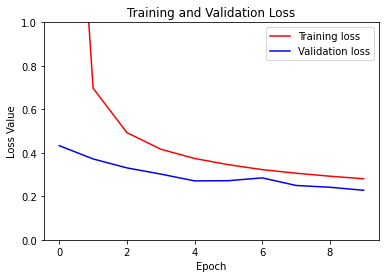

In [26]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [27]:
model.save("batch_size_8_epoch_10.h5")

C:\Users\Arjit\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


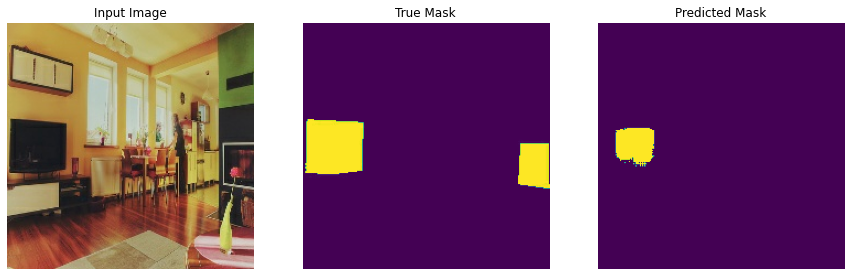

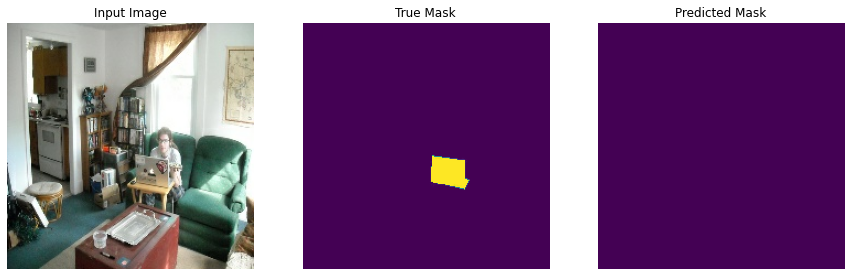

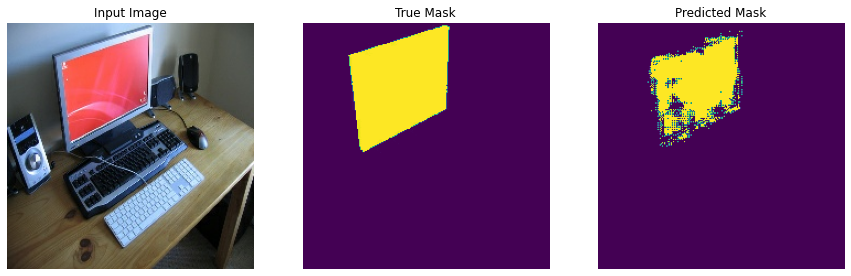

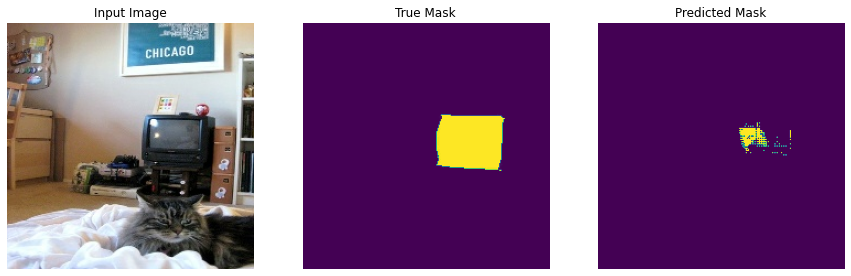

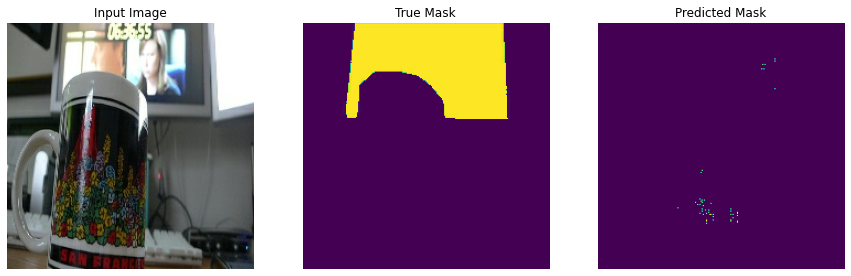

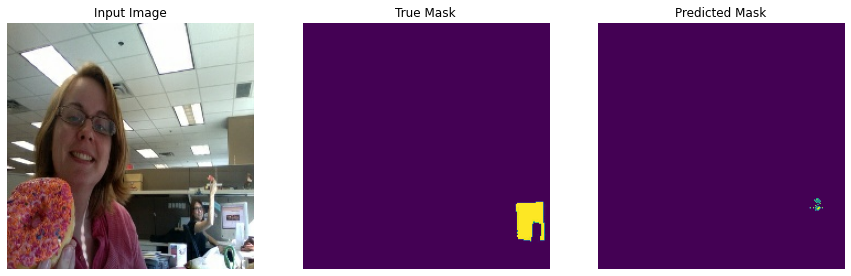

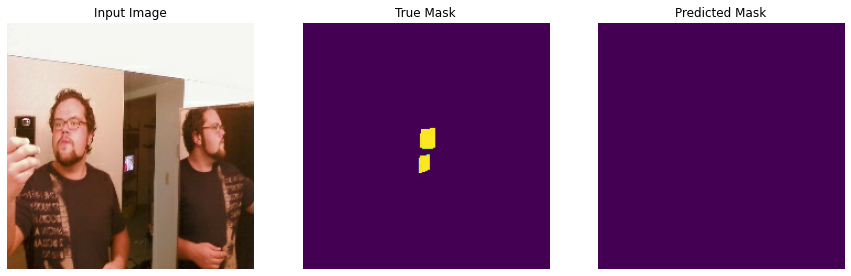

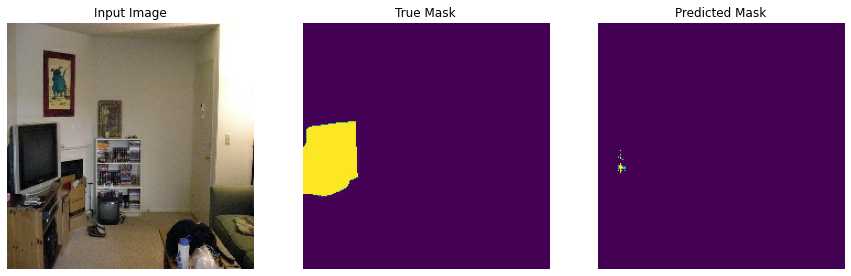

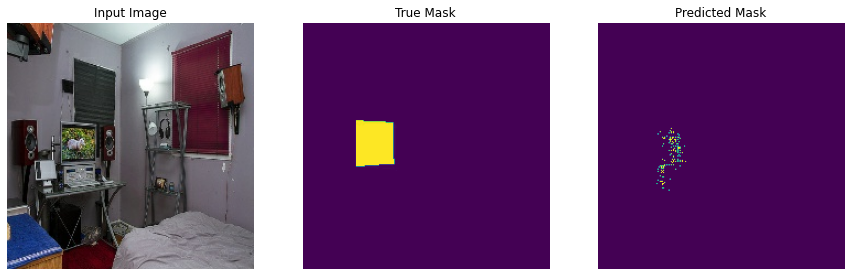

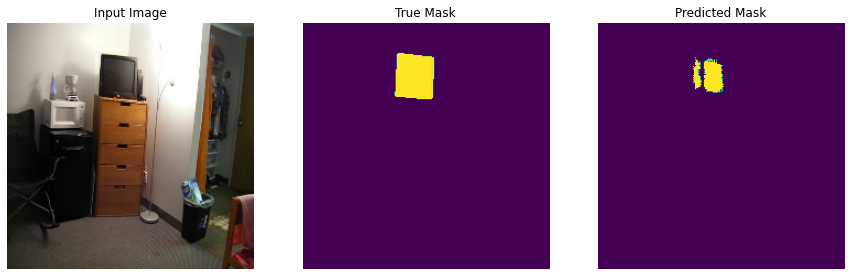

In [28]:
show_predictions(validation_dataset)

vid = cv2.VideoCapture(0)
img_size = (224,224)
output_size = (640,480)

while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
  
    # Display the resulting frame
    cv2.imshow('frame', frame)
    img = cv2.resize(frame,(224,224))
    img = tf.image.convert_image_dtype(img[tf.newaxis, ...], tf.float32) 
    img = create_mask(model.predict(img))
    img = tf.keras.preprocessing.image.array_to_img(img)
    img = np.array(img.getchannel(0))
    cv2.imshow('img',img)
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

In [55]:
cap = cv2.VideoCapture('vid1.mp4')

while(cap.isOpened()):
    ret, frame = cap.read()
    cv2.imshow('frame', frame)
    frame = cv2.resize(frame,(224,224))
    img = tf.image.convert_image_dtype(frame[tf.newaxis, ...], tf.float32) 
    img = create_mask(model.predict(img))
    img = tf.keras.preprocessing.image.array_to_img(img)
    img = np.array(img.getchannel(0))
    img = cv2.GaussianBlur(img, (7, 7), 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    rect, img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

    background = cv2.bitwise_not(img)
    background = cv2.bitwise_and(frame, frame, mask=background)

    masked_img = cv2.bitwise_and(frame, frame, mask=img)
    masked_img = cv2.GaussianBlur(masked_img, (27, 27), 2)
    img = cv2.bitwise_or(masked_img, background)
    img = cv2.resize(img,(352,640))
    cv2.imshow('imgage',img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 